<a href="https://colab.research.google.com/github/bk62/deep-learning-notebooks/blob/main/generative_deep_learning/03_VAE_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Preamble](#scrollTo=FmlA3iHeuVvM)

>[Sampling](#scrollTo=i7DVOt6BtIvL)

>[Encoder](#scrollTo=DXgUBTWCtZ_i)

>[Decoder](#scrollTo=E1gBisQitcFU)

>[VAE](#scrollTo=bRHGJPUxthOX)

>[Training](#scrollTo=WP4EIR6ntj_N)

>>[Loss](#scrollTo=WP4EIR6ntj_N)

>>[Define training loop methods](#scrollTo=dGqmX7_z0PtI)

>>[Dataset: Fashion MNIST](#scrollTo=uiAYYEDF0VZC)

>>[Training loop](#scrollTo=g8OjlnzH0iki)

>[Reconstruction](#scrollTo=wIPOMotzei4t)

>[Visualize latent space](#scrollTo=yRw0QpkgiPlX)

>>[Generating in the [min, max] bounding box of the latent space](#scrollTo=yPG0spqTOwbp)



# 0. Preamble

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import Pad, Compose

%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# 1. Sampling

Module that samples a latent vector $z$ from the normal distribution outputed by the encoder $N(\mu, \sigma)$

In [ ]:
class Sampling(nn.Module):
  def forward(self, inputs):
    z_mean, z_log_var = inputs
    n_batches = z_mean.shape[0]
    dim = z_mean.shape[1]
    eps = torch.randn(size=(n_batches, dim)).to(device)
    return z_mean + torch.exp(0.5 * z_log_var) * eps

# 2. Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, n=32, device=device):
    super().__init__()
    self.stack = nn.Sequential(
        # Conv 1
        nn.Conv2d(1, 32, 3, stride=2, padding=1),
        nn.ReLU(),

        # Conv 2
        nn.Conv2d(32, 64, 3, stride=2, padding=1),
        nn.ReLU(),

        # Conv 3
        nn.Conv2d(64, 128, 3, stride=2, padding=1),
        nn.ReLU(),

        # Flatten
        nn.Flatten(),
    )
    # Outputs:
    n_dim = n//8 * n//8 * 128
    # 1. z_mean
    self.mean = nn.Linear(n_dim, 2)
    # 2. z_log_var
    self.log_var = nn.Linear(n_dim, 2)
    # 3. z - sampled var
    self.sampling = Sampling().to(device)


  def forward(self, x):
    x = self.stack(x)
    z_mean = self.mean(x)
    z_log_var = self.log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z

enc = Encoder(32).to(device)
print(enc)

total_params = 0
for name, params in enc.named_parameters():
  print(name, params.numel())
  total_params += params.numel()
print(f"Total params: {total_params}")

Encoder(
  (stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (mean): Linear(in_features=2048, out_features=2, bias=True)
  (log_var): Linear(in_features=2048, out_features=2, bias=True)
  (sampling): Sampling()
)
stack.0.weight 288
stack.0.bias 32
stack.2.weight 18432
stack.2.bias 64
stack.4.weight 73728
stack.4.bias 128
mean.weight 4096
mean.bias 2
log_var.weight 4096
log_var.bias 2
Total params: 100868


# 3. Decoder

In [ ]:
class Decoder(nn.Module):
  def __init__(self, n):
    super().__init__()

    # Input layer
    # 2 -> 2048
    self.input = nn.Linear(2, n//8 * n//8 * 128)

    # Reshape required (see forward)
    # 2048 -> 4x4 128ch

    # Stack
    self.stack = nn.Sequential(
        # Note: padding=1, output_padding=1 added to ensure doubling of dimensions
        # See https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        # E.g.
        # p = 1
        # d = 1
        # o = 1
        # k = 3
        # Then, H = (4 - 1) * 2 - 2 * p + d * (k - 1) + o + 1

        # ConvT 1
        # 4x4 128ch -> 8x8 128ch
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

        # ConvT 2
        # -> 16x16 64ch
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

        # ConvT 3
        # -> 32x32 32ch
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

        # Output layer:
        # Conv 1
        # -> 32x32 1ch
        nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid(),

    )

  def forward(self, x):
    x = self.input(x)
    # batch size, # channels, d1, d2
    x = x.view(-1, 128, 4, 4)
    x = self.stack(x)
    return x


dec = Decoder(32).to(device)
print(dec)

total_params = 0
for name, params in dec.named_parameters():
  print(name, params.numel())
  total_params += params.numel()
print(f"Total params: {total_params}")

Decoder(
  (input): Linear(in_features=2, out_features=2048, bias=True)
  (stack): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)
input.weight 4096
input.bias 2048
stack.0.weight 147456
stack.0.bias 128
stack.2.weight 73728
stack.2.bias 64
stack.4.weight 18432
stack.4.bias 32
stack.6.weight 288
stack.6.bias 1
Total params: 246273


# 4. VAE

In [ ]:
class VAE(nn.Module):
  def __init__(self, n=32):
    super().__init__()

    self.encoder = Encoder(n)
    self.decoder = Decoder(n)

  def forward(self, x):
    z_mean, z_log_var, z = self.encoder(x)
    reconstruction = self.decoder(z)
    return z_mean, z_log_var, reconstruction

vae = VAE(32).to(device)
print(vae)

total_params = 0
for name, params in vae.named_parameters():
  print(name, params.numel())
  total_params += params.numel()
print(f"Total params: {total_params}")

VAE(
  (encoder): Encoder(
    (stack): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (mean): Linear(in_features=2048, out_features=2, bias=True)
    (log_var): Linear(in_features=2048, out_features=2, bias=True)
    (sampling): Sampling()
  )
  (decoder): Decoder(
    (input): Linear(in_features=2, out_features=2048, bias=True)
    (stack): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

# 5. Training

## Loss

Add KL loss term to the reconstruction loss.

KL divergence from standard normal $N(1, I)$ is:


$\textrm{KL loss} = -\frac{1}{2} \sum \left( 1 + \log (\sigma^2) - \mu^2 - \sigma^2 \right)
$

with the sum over all latent space dimensions.

Note,
$$
\textrm{z_log_var} = \log(\sigma^2) = 2 \log \sigma
$$
so,
$$
\sigma = \exp(0.5 \cdot \textrm{z_log_var})
$$

In [ ]:
reconstruction_loss = nn.BCELoss()

std_normal = torch.distributions.normal.Normal(0, 1)

# single batch - for sanity check
def kl_loss_manual(z_mean, z_log_var):
  sigma = torch.exp(0.5 * z_log_var)
  return -0.5 * torch.sum(1 + z_log_var - z_mean ** 2 - sigma ** 2, dim=1)

def vae_kl_loss(z_mean, z_log_var):
  z_dist = torch.distributions.normal.Normal(z_mean, torch.exp(0.5 * z_log_var))
  kl_loss = torch.distributions.kl_divergence(std_normal, z_dist)
  total_kl_loss = kl_loss.sum(dim=1) # sum across dims
  mean_kl_loss = total_kl_loss.mean() # mean across batches
  return mean_kl_loss

def total_vae_loss(X, z_mean, z_log_var, pred, beta=300):
  rc_loss = reconstruction_loss(pred, X)
  kl_loss = vae_kl_loss(z_mean, z_log_var)

  total_loss = beta * rc_loss + kl_loss
  return total_loss

def total_vae_loss_manual(X, z_mean, z_log_var, pred, beta=300):
  rc_loss = reconstruction_loss(pred, X)
  kl_loss = kl_loss_manual(z_mean, z_log_var).mean()

  total_loss = beta * rc_loss + kl_loss
  return total_loss


## Define training loop methods

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)

    # Forward
    z_mean, z_log_var, pred = model(X)
    loss = loss_fn(X, z_mean, z_log_var, pred)

    # Backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Metrics
    if batch % 100 == 0:
      loss, ix = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f} [{ix:>5d}/{size:>5d}]")

def rmse_metric(preds, target ):
    loss = torch.sum(torch.square(preds - target) , axis= 1)/(preds.size()[1])
    loss = torch.sum(loss)/loss.shape[0]
    return loss

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)

  model.eval()
  test_loss, rmse = 0, 0
  with torch.no_grad():
    for X, _ in dataloader:
      X = X.to(device)
      z_mean, z_log_var, pred = model(X)
      test_loss += loss_fn(X, z_mean, z_log_var, pred).item()
      rmse += rmse_metric(pred, X).item()
  test_loss /= num_batches
  rmse /= size
  print(f"Test Error: \n Avg RMSE: {rmse:>8f}, Avg loss: {test_loss:>8f} \n")

## Dataset: Fashion MNIST

In [ ]:
transforms = Compose([
    ToTensor(),  Pad(padding=(2, 2, 2, 2), fill=0, padding_mode="constant"),
])

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms
)

In [ ]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"X device: {X.device}, y device {y.device}")
    break

X, y = X.to(device), y.to(device)
X.device, y.device

Shape of X [N, C, H, W]: torch.Size([128, 1, 32, 32])
Shape of y: torch.Size([128]) torch.int64
X device: cpu, y device cpu


(device(type='cuda', index=0), device(type='cuda', index=0))

Sanity check

In [ ]:
x = X[0:10]
z_mean, z_log_var, z = vae.encoder(x)
x.shape, z_mean.shape, z_log_var.shape, z.shape

(torch.Size([10, 1, 32, 32]),
 torch.Size([10, 2]),
 torch.Size([10, 2]),
 torch.Size([10, 2]))

In [ ]:
z_mean

tensor([[ 0.0174,  0.0082],
        [-0.0020,  0.0134],
        [ 0.0019, -0.0043],
        [ 0.0024,  0.0069],
        [ 0.0037, -0.0006],
        [-0.0003,  0.0037],
        [ 0.0170,  0.0174],
        [ 0.0102,  0.0061],
        [ 0.0109,  0.0054],
        [ 0.0110,  0.0009]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
z_log_var

tensor([[-0.0404, -0.0108],
        [-0.0422, -0.0035],
        [-0.0463, -0.0005],
        [-0.0298,  0.0041],
        [-0.0315,  0.0022],
        [-0.0462, -0.0096],
        [-0.0434, -0.0046],
        [-0.0299, -0.0011],
        [-0.0402, -0.0076],
        [-0.0424, -0.0124]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
vae.encoder.sampling((z_mean, z_log_var))

tensor([[-1.1519, -0.5439],
        [-0.2882, -1.7698],
        [-1.4313,  0.1458],
        [ 1.5340,  1.2172],
        [ 1.2420, -0.5807],
        [ 0.4054, -0.3800],
        [-0.5226,  1.1988],
        [ 0.7602,  0.5550],
        [ 1.4434,  0.7199],
        [-0.3711,  0.8121]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
z_mean, z_log_var, z = vae.encoder(x)
z_log_var

tensor([[-0.0404, -0.0108],
        [-0.0422, -0.0035],
        [-0.0463, -0.0005],
        [-0.0298,  0.0041],
        [-0.0315,  0.0022],
        [-0.0462, -0.0096],
        [-0.0434, -0.0046],
        [-0.0299, -0.0011],
        [-0.0402, -0.0076],
        [-0.0424, -0.0124]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
recons = vae.decoder(z)
z.shape, recons.shape, x.shape

(torch.Size([10, 2]), torch.Size([10, 1, 32, 32]), torch.Size([10, 1, 32, 32]))

In [ ]:
z_mean, z_log_var, recons = vae(x)
recons.shape, x.shape

(torch.Size([10, 1, 32, 32]), torch.Size([10, 1, 32, 32]))

In [ ]:
kl_loss_manual(z_mean, z_log_var)

tensor([0.0006, 0.0005, 0.0005, 0.0002, 0.0003, 0.0006, 0.0008, 0.0003, 0.0005,
        0.0005], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
kl_loss_manual(z_mean, z_log_var).mean()

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
vae_kl_loss(z_mean, z_log_var)

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
total_vae_loss(x, z_mean, z_log_var, recons)

tensor(210.6017, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
500 * vae_kl_loss(z_mean, z_log_var)

tensor(0.2482, device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
reconstruction_loss(recons, x)

tensor(0.7020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
500 * vae_kl_loss(z_mean, z_log_var) + reconstruction_loss(recons, x)

tensor(0.9502, device='cuda:0', grad_fn=<AddBackward0>)

## Training loop

In [ ]:
opt = torch.optim.Adam(vae.parameters(), lr=1e-2)
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, vae, total_vae_loss_manual, opt)
    test(test_dataloader, vae, total_vae_loss_manual)
print("Done!")

Epoch 1
-------------------------------
loss: 210.245972 [  128/60000]
loss: 88.279221 [12928/60000]
loss: 84.004242 [25728/60000]
loss: 82.961327 [38528/60000]
loss: 86.275345 [51328/60000]
Test Error: 
 Avg RMSE: 0.215913, Avg loss: 83.517914 

Done!


In [ ]:
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, vae, total_vae_loss_manual, opt)
    test(test_dataloader, vae, total_vae_loss_manual)
print("Done!")

Epoch 1
-------------------------------
loss: 87.223358 [  128/60000]
loss: 81.383743 [12928/60000]
loss: 80.182297 [25728/60000]
loss: 81.181679 [38528/60000]
loss: 84.757484 [51328/60000]
Test Error: 
 Avg RMSE: 0.201169, Avg loss: 81.996445 

Epoch 2
-------------------------------
loss: 81.506935 [  128/60000]
loss: 81.523727 [12928/60000]
loss: 80.089302 [25728/60000]
loss: 81.323784 [38528/60000]
loss: 84.185646 [51328/60000]
Test Error: 
 Avg RMSE: 0.199201, Avg loss: 81.842487 

Epoch 3
-------------------------------
loss: 80.522003 [  128/60000]
loss: 81.497795 [12928/60000]
loss: 79.761093 [25728/60000]
loss: 80.958664 [38528/60000]
loss: 83.858810 [51328/60000]
Test Error: 
 Avg RMSE: 0.197127, Avg loss: 81.667340 

Epoch 4
-------------------------------
loss: 80.825424 [  128/60000]
loss: 81.112427 [12928/60000]
loss: 79.551643 [25728/60000]
loss: 80.523064 [38528/60000]
loss: 83.892822 [51328/60000]
Test Error: 
 Avg RMSE: 0.197359, Avg loss: 81.597073 

Epoch 5
--------

In [ ]:
opt = torch.optim.Adam(vae.parameters(), lr=1e-4)
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, vae, total_vae_loss, opt)
    test(test_dataloader, vae, total_vae_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 274.444122 [  128/60000]
loss: 122.500885 [12928/60000]
loss: 106.994904 [25728/60000]
loss: 99.428200 [38528/60000]
loss: 97.641159 [51328/60000]
Test Error: 
 Avg RMSE: 0.296275, Avg loss: 94.690648 

Epoch 2
-------------------------------
loss: 95.811661 [  128/60000]
loss: 93.366646 [12928/60000]
loss: 93.404533 [25728/60000]
loss: 91.304993 [38528/60000]
loss: 96.054718 [51328/60000]
Test Error: 
 Avg RMSE: 0.280771, Avg loss: 92.031662 

Done!


# 6. Reconstruction

In [ ]:
for (X_test, y_test) in train_dataloader:
  break

In [ ]:
X_test.shape

torch.Size([128, 1, 32, 32])

In [ ]:
_, _, reconstructed = vae(X_test.to(device))

In [ ]:
reconstructed.shape

torch.Size([128, 1, 32, 32])

In [ ]:
reconstructed = reconstructed.to("cpu").detach()

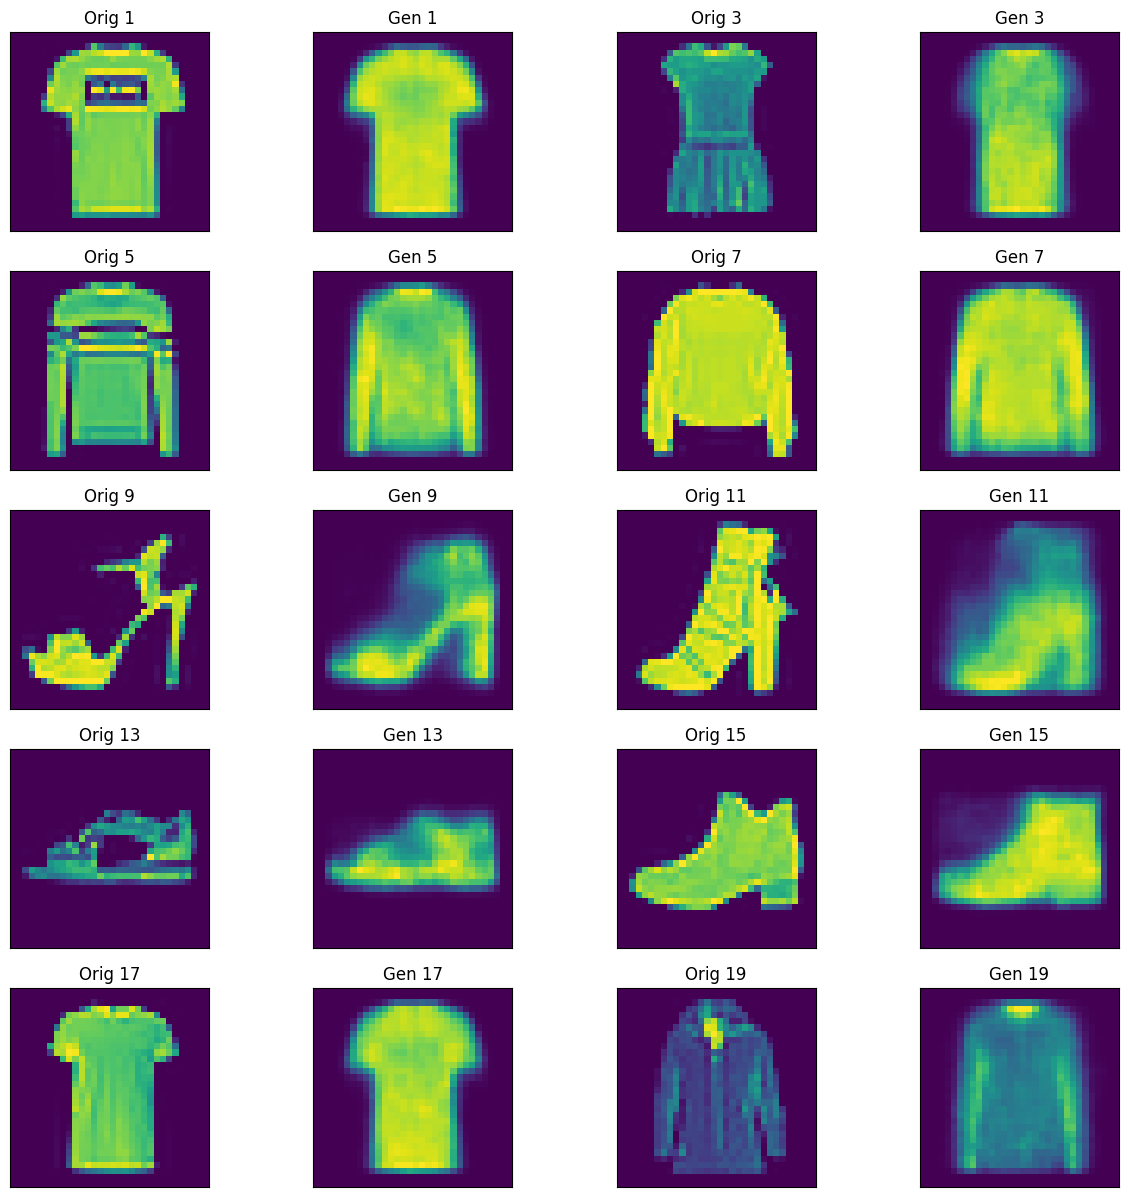

In [ ]:
fig = plt.figure(figsize=(15, 15))
for idx in torch.arange(1, 20, 2):
    ix = idx.item()
    ax = fig.add_subplot(5, 4, ix, xticks=[], yticks=[])
    ax.set_title(f"Orig {ix}")
    ax.imshow(torch.squeeze(X_test[idx]))
    ax = fig.add_subplot(5, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(reconstructed[idx]))
    ax.set_title(f"Gen {ix}")

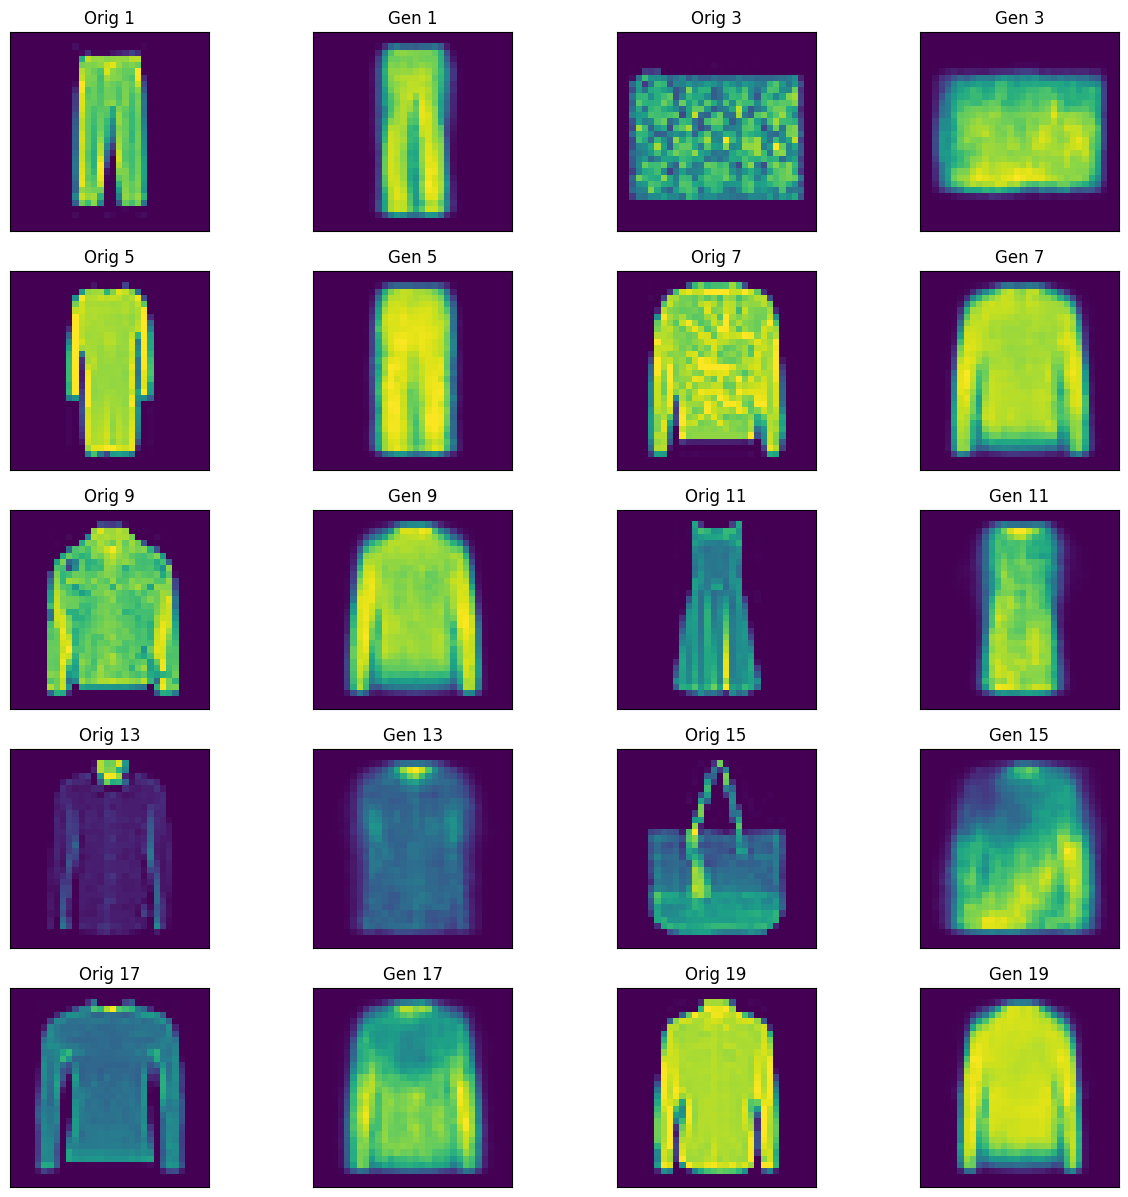

In [ ]:
fig = plt.figure(figsize=(15, 15))
for idx in torch.arange(1 + 20, 20 + 20, 2):
    ix = idx.item() - 20
    ax = fig.add_subplot(5, 4, ix, xticks=[], yticks=[])
    ax.set_title(f"Orig {ix}")
    ax.imshow(torch.squeeze(X_test[idx]))
    ax = fig.add_subplot(5, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(reconstructed[idx]))
    ax.set_title(f"Gen {ix}")

# 7. Visualize latent space

In [ ]:
embeddings, _, _ = vae.encoder(X_test.to(device))
embeddings = embeddings.to("cpu").detach()

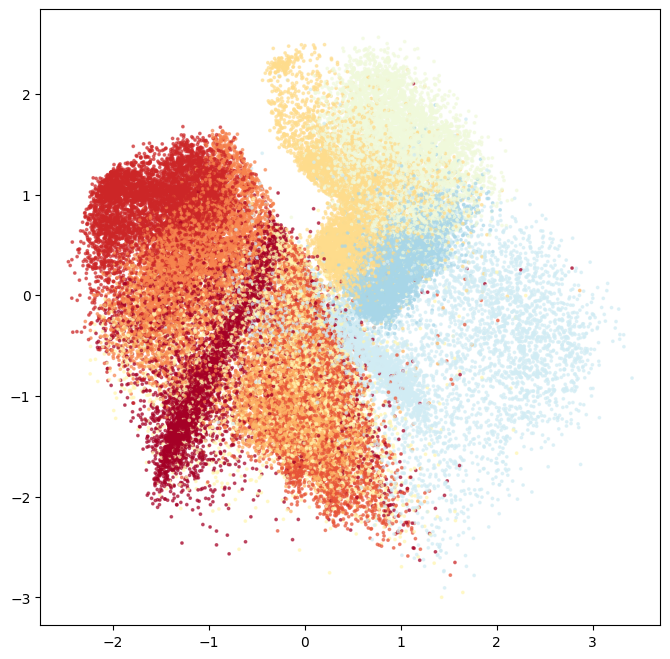

In [ ]:
plt.figure(figsize=(8, 8))
for (X_test, y_test) in train_dataloader:
  embeddings, _, _ = vae.encoder(X_test.to(device))
  embeddings = embeddings.to("cpu").detach()
  plt.scatter(embeddings[:, 0], embeddings[:, 1], color=plt.cm.RdYlBu(20*y_test), alpha=0.6, s=3)
  # break
plt.show()

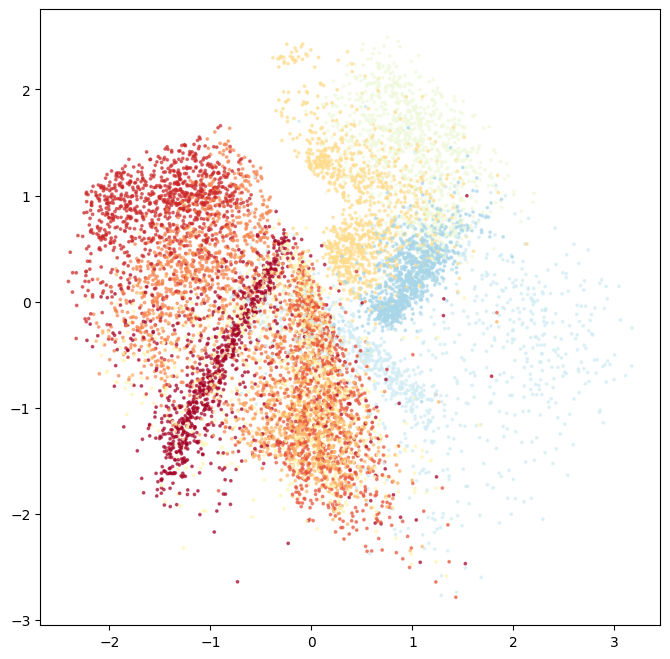

In [ ]:
plt.figure(figsize=(8, 8))
for (X_test, y_test) in test_dataloader:
  embeddings, _, _ = vae.encoder(X_test.to(device))
  embeddings = embeddings.to("cpu").detach()
  plt.scatter(embeddings[:, 0], embeddings[:, 1], color=plt.cm.RdYlBu(20*y_test), alpha=0.6, s=3)
  # break
plt.show()

## Generating in the [min, max] bounding box of the latent space

In [ ]:
mins, maxs = torch.min(embeddings, 0).values, torch.max(embeddings, 0).values

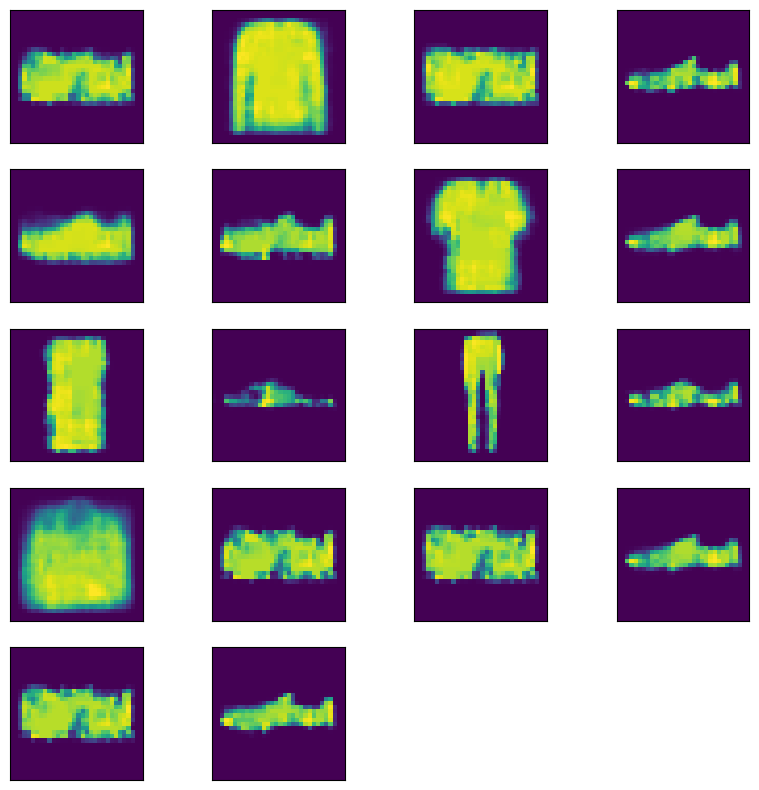

In [ ]:
sample = (mins - maxs) * torch.randn((18, 2)) + maxs
recons = vae.decoder(sample.to(device))

n = recons.shape[0]
recons = recons.to("cpu").detach()

fig = plt.figure(figsize=(10, 10))
for idx in torch.arange(n):
    ix = idx.item()
    ax = fig.add_subplot(n//4 + 1, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(recons[idx]))

## Generating near the origin

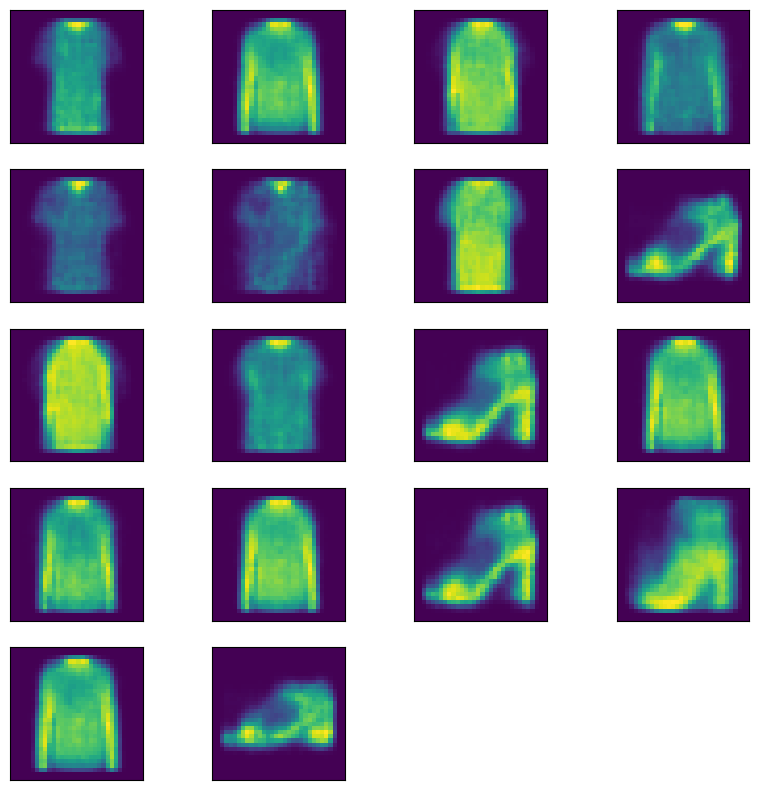

In [ ]:

sample = (0.5) * torch.randn((18, 2))
recons = vae.decoder(sample.to(device))

n = recons.shape[0]
recons = recons.to("cpu").detach()

fig = plt.figure(figsize=(10, 10))
for idx in torch.arange(n):
    ix = idx.item()
    ax = fig.add_subplot(n//4 + 1, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(recons[idx]))

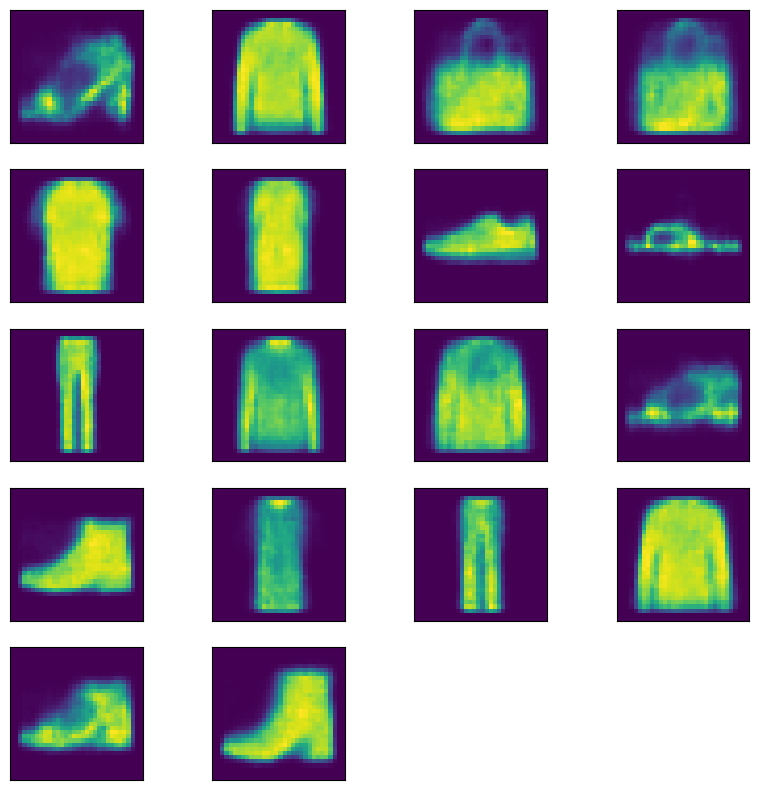

In [ ]:

sample = torch.randn((18, 2))
recons = vae.decoder(sample.to(device))

n = recons.shape[0]
recons = recons.to("cpu").detach()

fig = plt.figure(figsize=(10, 10))
for idx in torch.arange(n):
    ix = idx.item()
    ax = fig.add_subplot(n//4 + 1, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(recons[idx]))

## Generating along the axes

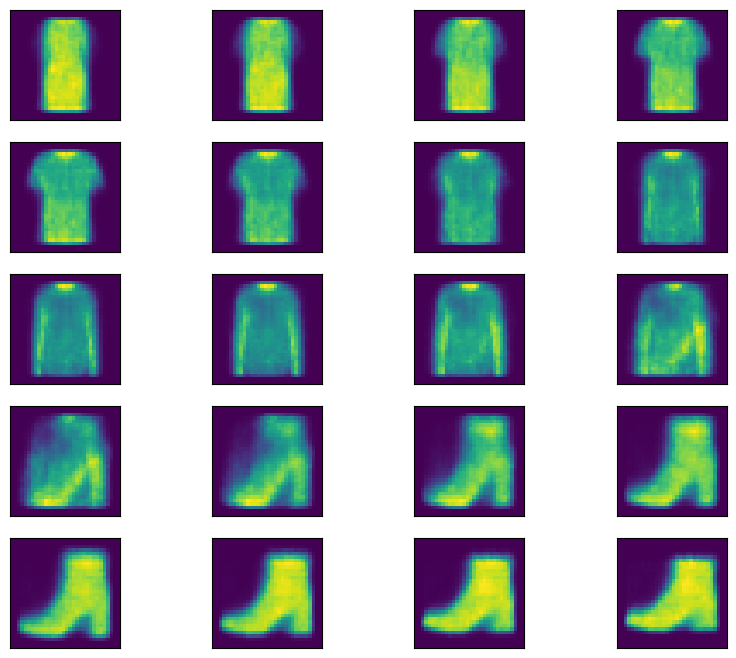

In [ ]:
sample = torch.zeros(20, 2)
sample[:, 0] = torch.linspace(-1, 1, 20)
recons = vae.decoder(sample.to(device))

n = recons.shape[0]
recons = recons.to("cpu").detach()

fig = plt.figure(figsize=(10, 10))
for idx in torch.arange(n):
    ix = idx.item()
    ax = fig.add_subplot(n//4 + 1, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(recons[idx]))

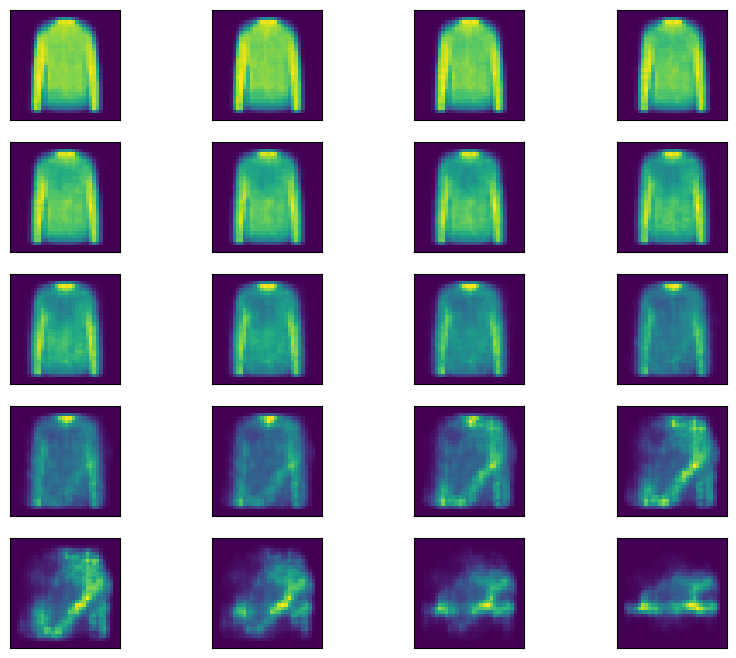

In [ ]:
sample = torch.zeros(20, 2)
sample[:, 1] = torch.linspace(-1, 1, 20)
recons = vae.decoder(sample.to(device))

n = recons.shape[0]
recons = recons.to("cpu").detach()

fig = plt.figure(figsize=(10, 10))
for idx in torch.arange(n):
    ix = idx.item()
    ax = fig.add_subplot(n//4 + 1, 4, ix + 1, xticks=[], yticks=[])
    ax.imshow(torch.squeeze(recons[idx]))